## **_Zajem gibanja telesa iz videa_**

Zajem gibanja temelji na uporabi Python knjižnice [OpenCV](https://opencv.org/), [cvzone](https://github.com/cvzone/cvzone) in [MediaPipe](https://developers.google.com/mediapipe). Knjižnica OpenCV je vodilna odprtokodna knjižnica za računalniški vid in zaznavanje. Vključuje optimizirane algoritme zaznave - od zaznav preprostih teles ali ljudi v realnem času, do kompleksnejših zaznav obraza in obrazne mimike, dlani in pozicij prstov, ljudi in pozicij okončin. 

Seveda na področju računalniškega vida obstaja veliko drugih Pythonovskih knjižnic, ki pa so nekoliko manj primerne kot OpenCV, zaradi visoke specializiacije na področje, ki ga rešujejo. 

Zaznavanje temelji na modelih strojnega učenja, tako OpenCV modelov in Googlovih MediaPipe modelov. Za potrebe te naloge smo z vmesnikom cvzone uporabili MediaPipe model za zaznavo telesnih mejnikov, s katerim smo uspešno posneli gibanje v 3D prostoru. Vmesnik cvzone ustvari "cevovod" med knjižnicama OpenCV in MediaPipe z objektom "PoseDetector" - zajem podatkov iz videa temelji na knjižnici OpenCV, zaznava telesnih mejnikov pa na MediaPipe modelu. 

MediaPipe model strojnega učenja za zaznavo telesnih mejnikov temelji na knjižnici ročno označenih slik. Kot predlagajo [v dokumentaciji](https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md), je rezultat najboljši, ko je subjekt v razdalji 2-4m od kamere. Model smo izbrali zaradi dobrih rezultatov v primerjavi z ostalimi vodilnimi javno dostopnimi modeli, kjer MediaPipe-ov BlazePose model [izstopa](https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md#pose-estimation-quality). 

Objekt PoseDetector nam ob uspešni zaznavi vrne seznam telesnih mejnikov in njihovih koordinat v 3D prostoru. Izkaže se, da so koordinate x in y, ki predstavljata širino in višino, zelo zanesljive, medtem ko je koordinata z, ki predstavlja globino, potrebovala nekoliko več post procesiranja. Zajem gibanja je tako bil presenetljivo zanesljiv, kljub uporabi samo ene kamere. 

![XYZ](./images/XYZ.png)

Slika predstavlja koordinatni sistem zajema gibanja in telesne mejnike, ki jih PoseDetector zazna. Zazna 33 mejnikov, večinoma pregibe telesa (sklepi - levi in desni komolec, kolena ipd.), dlani in nekaj mejnikov z obraza (nos, oči, obrvi in usta).  

## **_Uporaba_**

OpenCV uporablja različice jezika Python do 3.11, zato je potrebno ustvariti Anaconda virtualno, Python okolje. Anaconda je vmesnik, ki nam omogoča ustvarjanje Pythonovskih okolji z različnimi različicami in nameščenimi knjižnicami ter je uporabno predvsem kadar zunanje knjižnice potrebuje specifične različice jezika Python.

Za preglednost kode smo uporabili Jupyter Notebook, ki omogoča ustvarjanje celic s kodo in Markdown celic za tekst in predstavitvene slike ali gife.

- Namestitev: [Anaconda](https://www.anaconda.com/download).
- Z uporabo **Anaconda Prompt terminala**:
    - ustvarimo novo Python 3.11 Anaconda okolje:
      ~~~
      conda create --name motion_capture python=3.11
      ~~~
    - Zaženemo novo okolje in z modulom pip naložimo potrebne knjižnice:
      ~~~
      conda activate motion_capture
      ~~~
      ~~~
      pip install numpy
      pip install pandas
      pip install opencv-python
      pip install cvzone
      pip install mediapipe
      pip install notebook
      ~~~
    - Prestavimo se v delovno datoteko in zaženemo jupyter notebook:
      ~~~
      jupyter notebook
      ~~~
  

## **_Zajem gibanja in shranjevanje podatkov_**

In [1]:
#IMPORTS
import cv2
from cvzone.PoseModule import PoseDetector

In [89]:
video_str = 'videos/motion_full.mp4'

cap = cv2.VideoCapture(video_str)

#Getting width and height of video
width = int(cap.get(3))
height = int(cap.get(4))

""" Saving video with track overlay 
#Creating a VideoWriter object to save video with tracked landmarks and bbox
res = cv2.VideoWriter('motion_tracked.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      30, (width,height))
                      
"""
detector = PoseDetector()
posList = []    #list to store coordinates of landmarks
while True:
    success, img = cap.read()

    if success:
        img = detector.findPose(img)
        lmList, bboxInfo = detector.findPosition(img)    #detected landmark list and bounding box info, lmList is always of length 33
        
        
        if bboxInfo:
            lmString = ''
            for lm in lmList:
                #print(lm)    #lm format: [x, y, z]
                lmString += f'{lm[0]},{img.shape[0] - lm[1]},{lm[2]},'
            posList.append(lmString)
                
        #res.write(img)    #writing frame to output video
        cv2.imshow("Image", img)
        key = cv2.waitKey(1)
        if key == ord('s'):
            #with open("motion_data.txt", 'w') as f:
                #f.writelines(["%s\n" % item for item in posList])
            break
    else:
        with open("motion_data.txt", 'w') as f:
            f.writelines(["%s\n" % item for item in posList])
        break

cap.release()
#res.release()
cv2.destroyAllWindows()

![clip with overlay](tracked.gif)

Rezultat zajema gibanja je tako txt datoteka s surovimi podatki v vrsticah v formatu:
~~~
x0,y0,z0,x1,y1,z1, ..., xn,yn,zn, ... x32,y32,z32
~~~
Vsak trojček __xn, yn, zn__ predstavlja x, y, z koordinate n-tega od 33-ih zaznanih mejnikov v dani sličici posnetka, vsaka sličica posnetka pa je predstavljena kot ena vrstica v txt datoteki.

Vizualizacijo zajema gibanja smo prikazali tudi na surovem posnetku gibanja, odsek katere je viden zgoraj.

## **_Procesiranje surovih podatkov zajema gibanja_**

In [2]:
import csv

In [23]:
"""
Podatke shranimo v csv, vsaka vrstica je formata: [frame index, landmark index, x, y, z]
"""

pointsList = []
lines = []
with open("motion_data.txt", 'r') as f:
    lines = f.readlines()

csv_file = open("parsed_mocap.csv", 'w')
writer = csv.writer(csv_file)

frame_ix = 0
for line in lines:
    points = line.split(',')
    points.pop()
    if len(points) != 99:
        print(len(points), frame_ix)

    for i in range(0, 33):
        landmark_ix = i
        x = float(points[0 + (i * 3)])/100
        y = float(points[1 + (i * 3)])/100
        z = float(points[2 + (i * 3)])/300        #additional
        row = [frame_ix, landmark_ix, x, y, z]
        writer.writerow(row)
    
    pointsList.append(points)
    frame_ix+=1
csv_file.close()

![OpenCV, mediapipe landmarks](./images/pose_detection_topology.jpg)

Surove podatke txt datoteke smo glede na zgornjo sliko shranili v urejen csv, kjer je vsaka vrstica v formatu:
~~~
indeks sličice,indeks mejnika,x,y,z
~~~
Urejeni podatki nam olajšajo kakršno koli dodatno post procesiranje podatkov in vizualizacijo. Za lažje ustvarjanje in analizo podatkovnih naborov uporabimo knjižnico [Pandas](https://pandas.pydata.org/).

In [3]:
import pandas as pd

In [24]:
"""
Trenutno nas mejniki obraza ne zanimajo, zato jih lahko večino izpustimo - ohranimo le mejnik za nos, da ohranimo približno lokacijo glave.
Za preglednost prav tako ločimo podatke na posamezne mejnike; podatki vsake mejnika v svojo csv datoteko.
"""

column_names = ['frame_ix', 'landmark_ix', 'x', 'y', 'z']
df = pd.read_csv('parsed_mocap.csv', names=column_names)
df.to_csv('parsed_mocap.csv', index=False)    #updating with column names

landmark_names = ['nose', 'right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow', 'right_wrist', 'left_wrist', 'right_hip', 'left_hip', 'right_knee', 
                  'left_knee', 'right_ankle', 'left_ankle', 'right_heel', 'left_heel', 'right_foot', 'left_foot']
landmark_ixs = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
lm_todrop = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22]

"""
#Selecting landmark mocap data and saving it to separate datasets
df_nose = df.loc[df['landmark_ix'] == 0]
df_nose = df_nose.drop('landmark_ix', axis=1)
df_nose = df_nose.reset_index(drop=True)
df_nose.to_csv("./landmark_data/nose.csv", header=False, index=False)
"""
def separate_lm_data():
    for i in range(len(landmark_ixs)):
        df_lm = df.loc[df['landmark_ix'] == landmark_ixs[i]]
        df_lm = df_lm.drop('landmark_ix', axis=1)
        df_lm = df_lm.reset_index(drop=True)
        csv_string = './landmark_data/' + landmark_names[i] +'.csv'
        df_lm.to_csv(csv_string, header=False, index=False)
        #print(csv_string, landmark_ixs[i])

def drop_irrelevant():
    df_rel = df.apply(lambda row: row[~df['landmark_ix'].isin(lm_todrop)])
    df_rel.to_csv('cleaned_lm.csv', header=False, index=False)


In [25]:
separate_lm_data()

In [26]:
drop_irrelevant()

## **_Vizualizacija_**

Podatke želimo prikazati v animiranem 3D grafu, kjer vsaka točka v grafu predstavlja en zaznan mejnik. To dosežemo z uporabo knjižnice [Matplotlib](https://matplotlib.org/).

In [4]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [8]:
#Separating data into x, y, z data lists for drawing
x, y, z = [], [], []
with open('cleaned_lm.csv') as f:
    rows = csv.reader(f)
    i = 0;
    for row in rows:
        if i == 17:
            break;
        else:
            #print(row)
            x.append(float(row[2]))
            y.append(float(row[3]))
            z.append(float(row[4]))
            i+=1

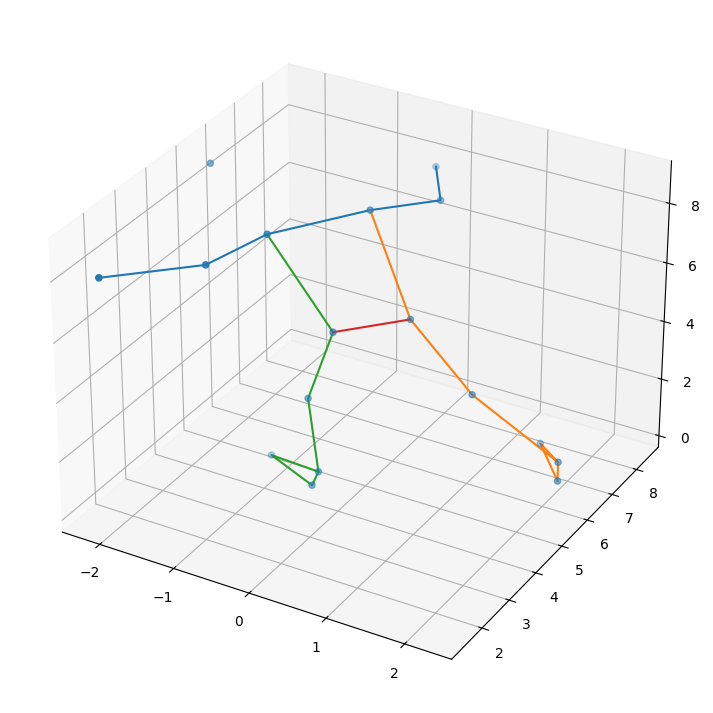

In [17]:
#Plotting frame 0
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(z,x,y)
#landmark_ixs = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
#Plotting lines between landmark points - specific order of coords based on landmark indexes
#Arms & shoulders
tx = [x[5], x[3], x[1], x[2], x[4], x[6]]
ty = [y[5], y[3], y[1], y[2], y[4], y[6]]
tz = [z[5], z[3], z[1], z[2], z[4], z[6]]
lines = ax.plot(tz,tx,ty)

#Body
tx = [x[1], x[7], x[9], x[11], x[13], x[15], x[11]]
ty = [y[1], y[7], y[9], y[11], y[13], y[15], y[11]]
tz = [z[1], z[7], z[9], z[11], z[13], z[15], z[11]]
lines = ax.plot(tz, tx, ty)

tx = [x[2], x[8], x[10], x[12], x[14], x[16], x[12]]
ty = [y[2], y[8], y[10], y[12], y[14], y[16], y[12]]
tz = [z[2], z[8], z[10], z[12], z[14], z[16], z[12]]
lines = ax.plot(tz, tx, ty)

tx = [x[7], x[8]]
ty = [y[7], y[8]]
tz = [z[7], z[8]]
lines = ax.plot(tz, tx, ty)

plt.show()

Zgornji 3D graf predstavlja eno izmed sličic zajetega gibanja. Z uporabo vizualizacije smo tako tudi prilagodili dodatno procesiranje podatkov - izkazalo se je, da MediaPipe-ov model za zaznavo pozicij **preceni** globino, torej, z-koordinato zaznanega mejnika. Izkaže se, da je za vizualizacijo gibanja to boljše kakor podcenjevanje globine, saj lažje omejimo vrednosti z-koordinat, kot pa jih raztegnemo. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

#ANIMATING
Xs, Ys, Zs = [], [], []

with open('cleaned_lm.csv') as f:
    rows = csv.reader(f)
    i = 0
    x, y, z, = [], [], []
    for row in rows:
        if i == 17:
            Xs.append(x)
            Ys.append(y)
            Zs.append(z)
            
            x, y, z = [], [], []
            
            i = 1
            x.append(float(row[2]))
            y.append(float(row[3]))
            z.append(float(row[4]))
        else:
            #print(row)
            x.append(float(row[2]))
            y.append(float(row[3]))
            z.append(float(row[4]))
            i+=1

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-8,8)
ax.set_ylim(0,8)
ax.set_zlim(0,10)

sc = ax.scatter(Zs[0],Xs[0],Ys[0])

x, y, z = Xs[0], Ys[0], Zs[0]
#Arms & shoulders
tx = [x[5], x[3], x[1], x[2], x[4], x[6]]
ty = [y[5], y[3], y[1], y[2], y[4], y[6]]
tz = [z[5], z[3], z[1], z[2], z[4], z[6]]
sc = ax.plot(tz,tx,ty)

#Body
tx = [x[1], x[7], x[9], x[11], x[13], x[15], x[11]]
ty = [y[1], y[7], y[9], y[11], y[13], y[15], y[11]]
tz = [z[1], z[7], z[9], z[11], z[13], z[15], z[11]]
sc = ax.plot(tz, tx, ty)

tx = [x[2], x[8], x[10], x[12], x[14], x[16], x[12]]
ty = [y[2], y[8], y[10], y[12], y[14], y[16], y[12]]
tz = [z[2], z[8], z[10], z[12], z[14], z[16], z[12]]
sc = ax.plot(tz, tx, ty)

tx = [x[7], x[8]]
ty = [y[7], y[8]]
tz = [z[7], z[8]]
sc = ax.plot(tz, tx, ty)

def animate(i):
    ax.clear()
    
    ax.set_xlim(-8,8)
    ax.set_ylim(0,8)
    ax.set_zlim(0,10)

    ax.view_init(azim=i)
    sc = ax.scatter(Zs[i], Xs[i], Ys[i])
    
    x, y, z = Xs[i], Ys[i], Zs[i]
    #Arms & shoulders
    tx = [x[5], x[3], x[1], x[2], x[4], x[6]]
    ty = [y[5], y[3], y[1], y[2], y[4], y[6]]
    tz = [z[5], z[3], z[1], z[2], z[4], z[6]]
    sc = ax.plot(tz,tx,ty)
    
    #Body
    tx = [x[1], x[7], x[9], x[11], x[13], x[15], x[11]]
    ty = [y[1], y[7], y[9], y[11], y[13], y[15], y[11]]
    tz = [z[1], z[7], z[9], z[11], z[13], z[15], z[11]]
    sc = ax.plot(tz, tx, ty)
    
    tx = [x[2], x[8], x[10], x[12], x[14], x[16], x[12]]
    ty = [y[2], y[8], y[10], y[12], y[14], y[16], y[12]]
    tz = [z[2], z[8], z[10], z[12], z[14], z[16], z[12]]
    sc = ax.plot(tz, tx, ty)
    
    tx = [x[7], x[8]]
    ty = [y[7], y[8]]
    tz = [z[7], z[8]]
    sc = ax.plot(tz, tx, ty)

    return sc


anim = animation.FuncAnimation(fig, animate, repeat=True, frames=len(Xs)-1, interval=50)

# To save the animation using Pillow as a gif

writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
anim.save('scatter_lines.gif', writer=writer)

#plt.show()

![Scatter Plot](scatter_lines.gif)

Animiran graf predstavlja zajem gibanja celotnega posnetka. Izkaže se, da model dobro obravnava tudi izgubo vidnosti mejnika. V tem primeru je iz vizualizacije razvidno, da se vrednost koordinat izgubljenih mejnikov dajo na privzeto pozicijo. 

V našem primeru se to zgodi pri rokah, ko se zaradi zakrivanja roke s telesom le-ta izgubi. Model nastavi privzeto vrednost roke v "sproščen, viseč" položaj poleg telesa, glede na lokacijo telesa in zaznanih proporcij. Napaka tako deluje relativno "naravno", saj je izgubljen mejnik ohranjen v bližini ostalih; najbolj opazno je, ko se mejnik znova zazna in se uporabijo dejanske, zaznane vrednosti. Uporaba dveh kamer se izkaže za bolj zamudno; zaradi estimacije koordinatnega sistem 

To bi lahko zamaskirali z interpolacijo med točkami, med zadnjo sličico posnetka z zaznanimi mejniki, pred izgubo mejnika, in prvo sličico posnetka, ko je izgubljen mejnik znova zaznan. 

Originalnega cilja zaznave prenosa sil v udarcu nismo dosegli, saj se je izkazalo, da gre za netrivialen problem - samo iz zajetega gibanja to, žal, ni mogoče. Potrebovali bi dodatne podatke, kot so teža subjekta, merilo z znano dolžino v prostoru (za estimacijo dolžine prepotovane poti in hitrosti s katero je bila prepotovana), približno ploščino udarjene poveršine ... Ti dodatni podatki so načeloma rešljivi, problem pa se pojavi pri dejanskem prenosu teže iz ene noge na drugo in načina estimacije teže "za udarcem", torej, koliko teže na "sprednji nogi" se dejansko prenese v udarec.

## **_Viri_**
 - OpenCV dokumentacija, _https://docs.opencv.org/4.x/_
 - MediaPipe dokumentacija, _https://developers.google.com/mediapipe/api/solutions/python/mp_
 - CVzone dokumentacija, _https://github.com/cvzone/cvzone_
 - Primerjava modelov zaznavanja poz, _https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md#pose-estimation-quality_
 - Knjižnica Pandas, _https://pandas.pydata.org/_
 - Razvojno okolje Anaconda, _https://www.anaconda.com/_